In [10]:
import csv
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

# featurizer class definition

class Featurizer():
    
    def __call__(self, df):
        fingerprints = []
        labels = []
        
        df = df[df['Ki']<=1e4]
        df = df[df['Ki']>0.01]
        labels = df['Ki']
        
        fp = []
        for index, row in df.iterrows():
            fp = row[1:]
            fingerprints.append(fp)
            
        fingerprints = np.array(fingerprints)
        labels = np.array(labels)
        return fingerprints, labels

In [11]:
# text file to DataFrame object

filename = '../cleaned_datasets/d2_Sub_clean.csv'
df = pd.read_csv(filename)
df = df.dropna()

featurizer = Featurizer()
fp_train, ki_train = featurizer(df)

fp_train = torch.from_numpy(fp_train)
ki_train = torch.from_numpy(ki_train)

assert fp_train.shape[0] == ki_train.shape[0], 'X_train and y_train rows do not match'

In [12]:
fp_train.shape

torch.Size([9249, 139])

In [13]:
# data loader

from torch.utils.data import DataLoader, TensorDataset

tensor_ds = TensorDataset(fp_train, ki_train)

train_dataloader = DataLoader(tensor_ds, batch_size=64, shuffle=True)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

# define variational autoencoder class

class Encoder(nn.Module):
    def __init__(self, input_size, output_size):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc41 = nn.Linear(16, output_size)
        self.fc42 = nn.Linear(16, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        h3 = self.relu(self.fc3(h2))
        mu = self.fc41(h3)
        logvar = self.fc41(h3)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        h3 = self.relu(self.fc3(h2))
        out = self.fc4(h3)
        return self.sigmoid(out)

class VAE(nn.Module):
    def __init__(self, input_size, latent_size):
        torch.set_default_dtype(torch.float64)
        super(VAE, self).__init__()
        self.encoder = Encoder(input_size, latent_size)
        self.decoder = Decoder(latent_size, 128, input_size)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


In [16]:
# define VAE loss function

class VAELoss(nn.Module):
    def __init__(self):
        super(VAELoss, self).__init__()

    def forward(self, recon_x, x, mu, logvar):
        BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD

In [39]:
# train
import matplotlib.pyplot as plt
from IPython.display import clear_output

def train_VAE(train_dataloader, fp_len, epochs=40, device=device, latent_size=8, plot_loss=False):
    model = VAE(input_size=fp_len, latent_size=latent_size)
    criterion = VAELoss()
    if device == 'cuda':
        model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    losses = []
    if plot_loss:
        fig, ax = plt.subplots()
        dh = display(fig, display_id=True)
    for epoch in tqdm(range(1, epochs+1)):
        for (fp, _) in train_dataloader:
            if device == 'cuda':
                fp = fp.cuda()
            encoded, mu, logvar = model(fp)
            loss = criterion(encoded, fp, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        if plot_loss:
            ax.clear()
            ax.plot(losses)
            ax.set_title(f'Epoch {epoch}, Loss: {loss.item():.2f}')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            dh.update(fig)
            
    return model, losses

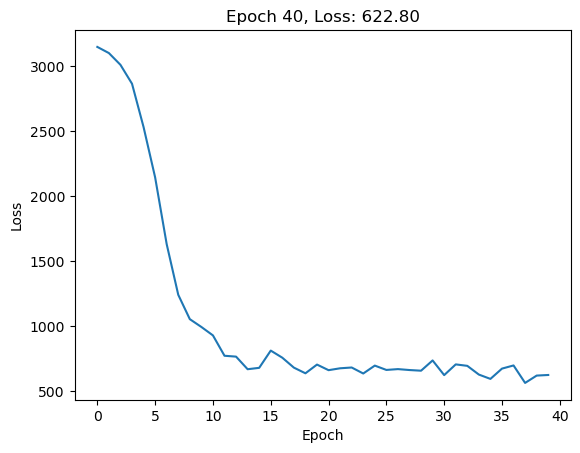

  0%|          | 0/40 [00:00<?, ?it/s]

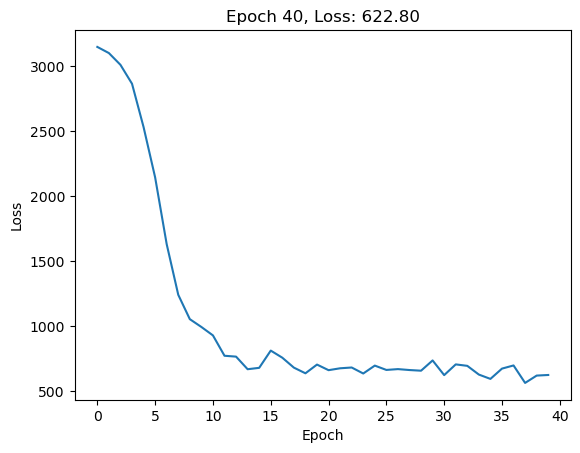

In [40]:
model, loss = train_VAE(train_dataloader, fp_len=fp_train.size(dim=1), plot_loss=True)

In [41]:
# encode all data to latent space
encoded = []
for fp in fp_train:
    encoder = model.encoder
    if device == 'cuda':
        fp = fp.cuda()
        mu, logvar = encoder(fp)
        latent = model.reparameterize(mu, logvar)
        encoded.append(latent.detach().cpu().numpy())
    else:
        mu, logvar = encoder(fp)
        latent = model.reparameterize(mu, logvar)
        encoded.append(latent.detach().numpy())

In [42]:
encoded = np.array(encoded)

In [ ]:
class CVAEEncoder:
    

[Text(0.5, 1.0, 'Activity criterion = 50 nM')]

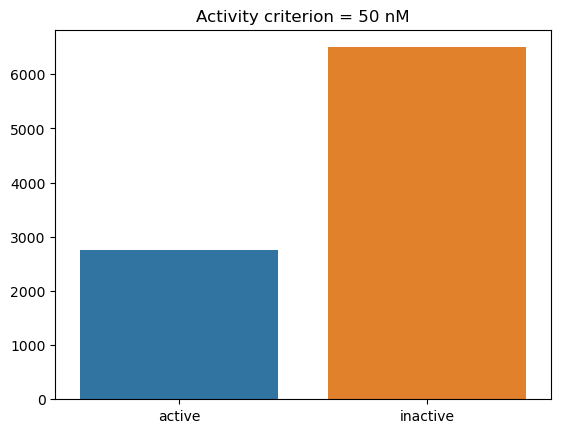

In [43]:
import seaborn as sns

# set activity criterion (ki < threshold)
threshold = 50 # (nM)

activity = (ki_train < threshold)
activity = np.array(activity, dtype='d')

# classes distribution

classes_df = pd.DataFrame()
classes_df['active'] = [np.sum(activity)]
classes_df['inactive'] = [len(activity) - np.sum(activity)]

sns.barplot(data=classes_df).set(title=f'Activity criterion = {threshold} nM')


In [44]:
# latent space data prep

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(encoded, activity, test_size=0.4, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

assert X_train.shape[0] == y_train.shape[0], 'X_train and y_train rows do not match'

In [45]:
# define predictor neural net class

class Predictor(nn.Module):
    def __init__(self, hidden1=32, hidden2=32, hidden3=16, input_size=8):
        super(Predictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.fc4 = nn.Linear(hidden3, 8)
        self.fc5 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        return torch.sigmoid(self.fc5(x))

In [65]:
from sklearn.metrics import roc_auc_score, accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
# define train function

def train_predictor(X_train, y_train, X_valid, y_valid, epochs=300, device=device):

    # valid prep
    
    fig, ax = plt.subplots(ncols=3, figsize=(9, 3), layout="constrained")
    dh = display(fig, display_id=True)
    df_metrics = pd.DataFrame()
    df_metrics['epoch'] = []
    df_metrics['loss'] = []
    df_metrics['ROC_AUC'] = []
    df_metrics['accuracy'] = []
    
    # dataset prep
    
    train_dataset = TensorDataset(X_train, y_train)
    valid_dataset = TensorDataset(X_valid, y_valid)
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
    
    # model training
    
    model = Predictor()
    
    if device == 'cuda':
        model.cuda()
        
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.BCELoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=100, verbose=True)
    
    for epoch in tqdm(range(1, epochs+1)):
        
        model.train()
        for X, y in train_dataloader:
            model.zero_grad()
            preds = model(X)
            loss = criterion(preds.reshape(-1), y)
            loss.backward()
            optimizer.step()
        
        # evaluation
        
        model.eval()
        preds_batches = []
        with torch.no_grad():
            for X, y in valid_dataloader:
                preds = model(X)
                preds_batches.append(preds.cpu().detach().numpy())
        preds = np.concatenate(preds_batches)
        preds = preds.reshape(-1)
        ROC_AUC = roc_auc_score(y_valid, preds)
        preds = preds < 0.5
        accuracy = accuracy_score(y_valid, preds)
        new_row = {'epoch':epoch, 'loss':loss.item(), 'ROC_AUC':ROC_AUC, 'accuracy':accuracy}
        df_metrics.loc[len(df_metrics)] = new_row
        val_loss = criterion(torch.from_numpy(preds).float(), y_valid.float())
        ax[0].clear()
        ax[0].plot(df_metrics.epoch, df_metrics.loss)
        ax[0].set_title('training loss')
        ax[0].set_xlabel('epoch')
        ax[0].set_ylabel('BCE')
        ax[1].clear()
        ax[1].plot(df_metrics.epoch, df_metrics.ROC_AUC)
        ax[1].set_title('validation ROC_AUC')
        ax[1].set_xlabel('epoch')
        ax[1].set_ylabel('ROC_AUC')
        ax[2].clear()
        ax[2].plot(df_metrics.epoch, df_metrics.accuracy)
        ax[2].set_title('validation accuracy')
        ax[2].set_xlabel('epoch')
        ax[2].set_ylabel('accuracy')
        dh.update(fig)
        scheduler.step(val_loss)
    plt.close()
    return model

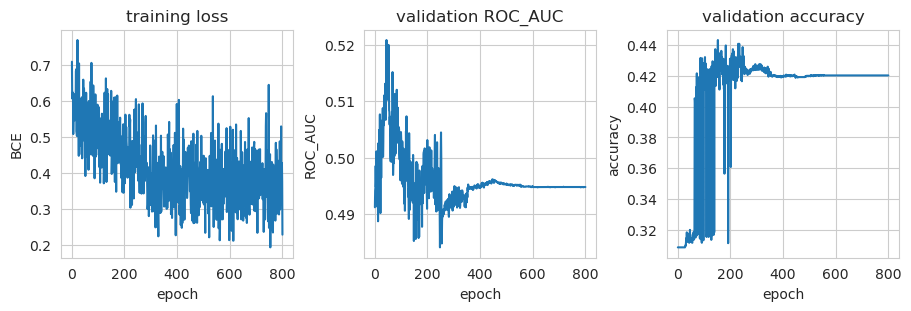

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch 00254: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00355: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00456: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00557: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00658: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00759: reducing learning rate of group 0 to 1.0000e-08.


In [66]:
# train predictor nn

predictor = train_predictor(X_train, y_train, X_test, y_test, epochs=800, device=device)

In [49]:
# plot latent space

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# pca reduction

pca = PCA(n_components=2)
pca_results = pca.fit_transform(encoded)
pca_results = pd.DataFrame(pca_results)
pca_results['activity'] = activity


In [50]:
# t-SNE reduction

print('...tSNE...')
tsne = tsne = TSNE(perplexity=20, learning_rate=100, verbose=1)
tsne_results = pd.DataFrame(tsne.fit_transform(encoded))
tsne_results['activity'] = activity

...tSNE...
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 9249 samples in 0.008s...
[t-SNE] Computed neighbors for 9249 samples in 1.593s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9249
[t-SNE] Computed conditional probabilities for sample 2000 / 9249
[t-SNE] Computed conditional probabilities for sample 3000 / 9249
[t-SNE] Computed conditional probabilities for sample 4000 / 9249
[t-SNE] Computed conditional probabilities for sample 5000 / 9249
[t-SNE] Computed conditional probabilities for sample 6000 / 9249
[t-SNE] Computed conditional probabilities for sample 7000 / 9249
[t-SNE] Computed conditional probabilities for sample 8000 / 9249
[t-SNE] Computed conditional probabilities for sample 9000 / 9249
[t-SNE] Computed conditional probabilities for sample 9249 / 9249
[t-SNE] Mean sigma: 0.644655
[t-SNE] KL divergence after 100 iterations with early exaggeration: 101.176750
[t-SNE] KL divergence after 1000 iterations: 3.122149


Text(0, 0.5, 'PC2')

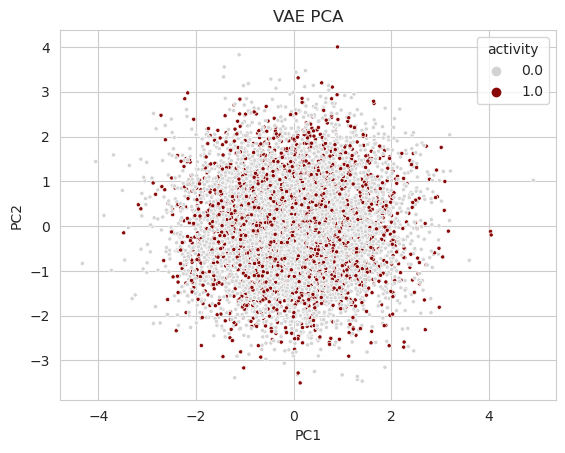

In [51]:
# plot PCA

sns.set_style('whitegrid')
colors = ['#D3D3D3', '#880808']
sns.scatterplot(x=0, y=1, hue='activity', data=pca_results, marker='.', palette=colors)
plt.title('VAE PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')

Text(0, 0.5, 'Ax2')

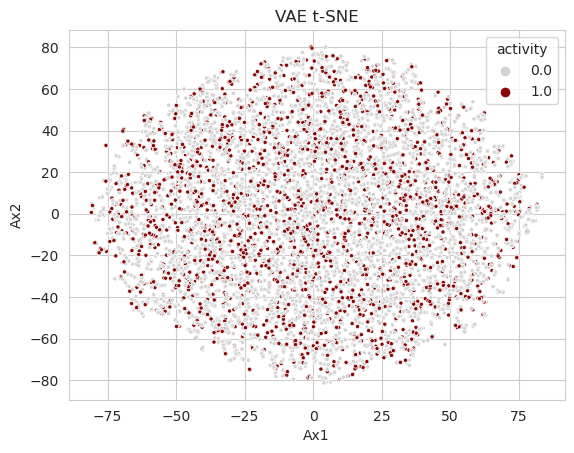

In [52]:
# plot t-SNE

sns.scatterplot(x=0, y=1, hue='activity', data=tsne_results, marker='.', palette=colors)
plt.title('VAE t-SNE')
plt.xlabel('Ax1')
plt.ylabel('Ax2')